# Train Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
data_path = 'P:\\MyWork\\demoHeaderPredictor\\data'
data_path_external = 'P:\\MyWork\\demoHeaderPredictor\\data\\external'
data_path_model = 'P:\\MyWork\\demoHeaderPredictor\\data\\model'

## Load train

In [3]:
training_data = pd.read_csv(os.path.join(data_path_model,'training_data.csv'))
training_data[:2]

,address1,address2,city,state,zip,lat,lng,money,reference,email,person_name,phone,first_name,last_name,txt_cat,num_cat,numeric
0,1745 T Street Southeast,NaN,Washington,DC,20020,38.867033,-76.979235,GBP 487760.350,SPCH308,mex@yahoo.com,Kimberlee Turlington,0345 42 0274,Kimberlee,Turlington,B,3,5181
1,6007 Applegate Lane,NaN,Louisville,KY,40219,38.134301,-85.649851,€ 7321963.108,VDEY870,rg@aol.com,Miguel Eveland,095086-173-31-37,Miguel,Eveland,A,4,2163


## Reshape Data

In [4]:
Xy = pd.concat([pd.DataFrame(data={'X':list(training_data[col]),'Y':col}) for col in training_data.columns])
Xy.reset_index(drop=True,inplace=True)
Xy.fillna('',inplace=True) # fill nan values with empty string
print(len(Xy))
Xy.sample(5)

34000


,X,Y
10678,39.8069,lat
19871,xwlhhx@gmail.com,email
27715,Thibert,last_name
7709,AL,state
21305,Elvin Abell,person_name


## Feat Engineering

create some features:
- length — The length of each string in characters
- num_length — The number of digits characters in a string
- space_length — The number of spaces within a string
- special_length — The number of special (non-alphanumeric) characters
- vowel_length

In [5]:
def feat_eng(df):
    df['X'] = df['X'].astype(str).copy()
    df['n_chars'] = df['X'].str.len() # 
    df['n_digits'] = df['X'].str.count(r'[0-9]')
    df['n_space'] = df['X'].str.count(r' ')
    df['n_special'] = df['X'].str.len() - df['X'].str.count(r'[\w+ ]')# special chars
    df['n_vowels'] = df['X'].str.count(r'(?i)[aeiou]') # vowels
    df.fillna(0)
    return df.fillna(0)

Xy = feat_eng(Xy)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='char',
                             lowercase=True,
                             stop_words=None,
                             max_df=1.0,
                             min_df=0.01,
                             ngram_range=(1,6),
                             # the following settings make the output tf matrix binary (exists or not)
                             binary=True,
                             norm=None,
                             use_idf=False
                            )

X_vect = vectorizer.fit_transform(Xy['X'].astype(str).str.encode('utf-8'))
print(X_vect.shape)


## test on single string
# test = vectorizer.transform(['ben@hotmail.com'])
# pd.DataFrame(data = test.todense(), columns=vectorizer.get_feature_names())

(34000, 413)


In [7]:
X_vect_df = pd.DataFrame(data = X_vect.todense(), columns=vectorizer.get_feature_names())
Xy_vect = Xy.merge(X_vect_df,how='left',left_index=True,right_index=True).copy()
#Xy_vect[['X','£']].loc[Xy_vect['X'].str.contains('£')==True]

## Feature Selection - univariate 
### [Chi-squared](https://machinelearningmastery.com/chi-squared-test-for-machine-learning/)

*The chi-square test is a statistical test of independence to determine the dependency of two variables. 
It shares similarities with coefficient of determination, R².
However, chi-square test is only applicable to categorical or nominal data while R² is only applicable to numeric data.*
 - If Statistic >= Critical Value: significant result, reject null hypothesis (H0), dependent. *There **IS** a relationship*.
 - If Statistic < Critical Value: not significant result, fail to reject null hypothesis (H0), independent. *There **IS NOT** a relationship*.

In [8]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2

prob = 0.95
alpha = 1.0 - prob

# run test
stat, p, dof, expected = chi2_contingency(pd.crosstab(Xy['Y'],Xy['n_vowels']))

# dof
print('\ndof=%d' % dof)

# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('\nprobability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('\tDependent (reject H0)')
else:
    print('\tIndependent (fail to reject H0)')
    
    
# interpret p-value
print('\nsignificance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('\tDependent (reject H0)')
else:
    print('\tIndependent (fail to reject H0)')


dof=240

probability=0.950, critical=277.138, stat=60001.619
	Dependent (reject H0)

significance=0.050, p=0.000
	Dependent (reject H0)


In [9]:
features = Xy_vect.columns[2:]
stats = list()
p_values = list()
dofs = list()

for feat in features:
    # run test
    stat, p, dof, expected = chi2_contingency(pd.crosstab(Xy_vect['Y'],Xy_vect[feat]))
    stats.append(stat)
    p_values.append(p)
    dofs.append(dof)

chi2_results = pd.DataFrame({'feature':features,'X2':stats,'DoF':dofs,'pvalue':p_values,'sig':[x<=0.05 for x in p_values]})
chi2_results.sort_values(by='X2',ascending=False, inplace=True)

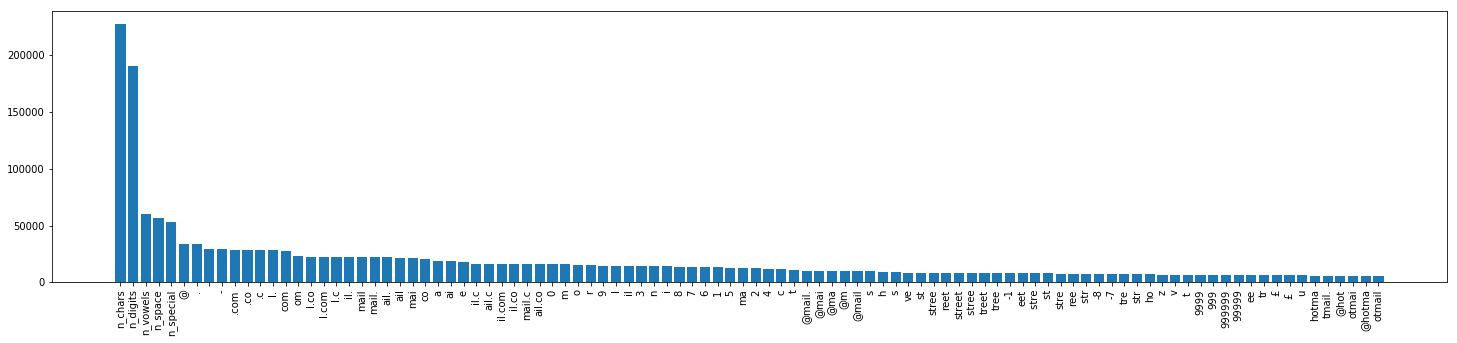

In [10]:
fig,axs = plt.subplots(figsize=(25,5))
n = 100
axs.bar(x = range(n), height=chi2_results['X2'][:n])
axs.set_xticks(range(n));
axs.set_xticklabels(chi2_results['feature'][:n],rotation=90);

# Model

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

In [12]:
model_features = chi2_results['feature'][:100].values

In [13]:
# model param
NB_params = {'model__alpha':(1e-1, 1e-3)}

NB_pipe = Pipeline([('model', MultinomialNB())])

gs_NB = GridSearchCV(NB_pipe, param_grid=NB_params, n_jobs=2, cv=5)
gs_NB = gs_NB.fit(Xy_vect[model_features], Xy_vect['Y'])
print(gs_NB.best_score_, gs_NB.best_params_)

0.7691470588235294 {'model__alpha': 0.1}


# Evaluate

In [14]:
from sklearn import metrics

In [15]:
test_data = pd.read_csv(os.path.join(data_path_model,'testing_data_1.csv'))

In [16]:
Xy_test = pd.concat([pd.DataFrame(data={'X':list(test_data[col]),'Y':col}) for col in test_data.columns])
Xy_test.reset_index(drop=True,inplace=True)
Xy_test.fillna('',inplace=True) # fill nan values with empty string

Xy_test = feat_eng(Xy_test)

test_vect = vectorizer.transform(Xy_test['X'].astype(str).str.encode('utf-8'))
test_vect = pd.DataFrame(data = test_vect.todense(), columns=vectorizer.get_feature_names())
Xy_test = Xy_test.merge(test_vect,how='left',left_index=True,right_index=True).copy()

In [18]:
NBcv_predict = gs_NB.predict(Xy_test[model_features])
print('NB-CV accuracy: %.3f' %np.mean(NBcv_predict == Xy_test['Y']))

NB-CV accuracy: 0.787


In [29]:
print(metrics.classification_report(Xy_test['Y'], NBcv_predict))

              precision    recall  f1-score   support

    address1       0.53      0.98      0.69        50
    address2       1.00      0.10      0.18        50
        city       0.74      0.58      0.65        50
       email       1.00      1.00      1.00        50
  first_name       0.48      0.60      0.53        50
   last_name       0.52      0.46      0.49        50
         lat       0.98      1.00      0.99        50
         lng       0.96      1.00      0.98        50
       money       0.98      1.00      0.99        50
     num_cat       0.78      1.00      0.88        50
     numeric       0.74      0.68      0.71        50
 person_name       0.87      0.96      0.91        50
       phone       1.00      0.90      0.95        50
   reference       1.00      1.00      1.00        50
       state       0.87      0.52      0.65        50
     txt_cat       0.72      1.00      0.84        50
         zip       0.70      0.60      0.65        50

   micro avg       0.79   

In [24]:
Xy_test['pred'] = NBcv_predict

In [27]:
Xy_test.loc[Xy_test['Y']=='money']

,X,Y,n_chars,n_digits,n_space,n_special,n_vowels,,1,2,...,wa,we,x,y,y,ya,z,£,£,pred
350,EUR 501294.594,money,14,9,1,1,2,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,money
351,GBP 9476080.592,money,15,10,1,1,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,money
352,USD 4866256.396,money,15,10,1,1,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,money
353,EUR 8243580.015,money,15,10,1,1,2,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,money
354,€ 1018042.368,money,13,10,1,2,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,money
355,EUR 1929714.884,money,15,10,1,1,2,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,money
356,USD 8618755.523,money,15,10,1,1,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,money
357,£ 3602775.036,money,13,10,1,2,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,money
358,EUR 8025818.873,money,15,10,1,1,2,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,money
359,GBP 6186315.427,money,15,10,1,1,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,money
